In [30]:
import os
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import seaborn as sns
import anndata as ad
import decoupler as dc

In [31]:
out_dir = "../../results/04_spatial/20_function_analysis_of_niches"
os.makedirs(out_dir, exist_ok=True)

In [32]:
sample_list = ['HC01', 'HC02', 'HC03', 'HC05',
               #'SSc4733', 
               'SSc4994', 'SSc5380', 
               #'SSc5722',
               'SSc-HL01', 'SSc-HL05', 'SSc-HL06', 'SSc-HL11',
               'SSc-HL13', 'SSc-HL25', 'SSc-HL33', 'SSc-HL35']

In [33]:
# read all spatial data
adata_dict = {}

for sample in sample_list:
    adata = sc.read_h5ad(f'../../results/04_spatial/09_run_cell2location/{sample}.h5ad')
    adata.obs['patient_id'] = sample
    adata.obs['barcode'] = adata.obs_names
    adata_dict[sample] = adata

In [62]:
adata = ad.concat(adata_dict, index_unique="_")

# add niche results
df = pd.read_csv('../../results/04_spatial/15_integrate_with_cell_proportion/niches.csv')
df.index = df['barcode'].astype(str) + "_" +  df['patient_id'].astype(str)
df = df.loc[adata.obs_names, ]
adata.obs['leiden'] = df['leiden'].astype(str)

In [63]:
adata.layers['counts'] = adata.X
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


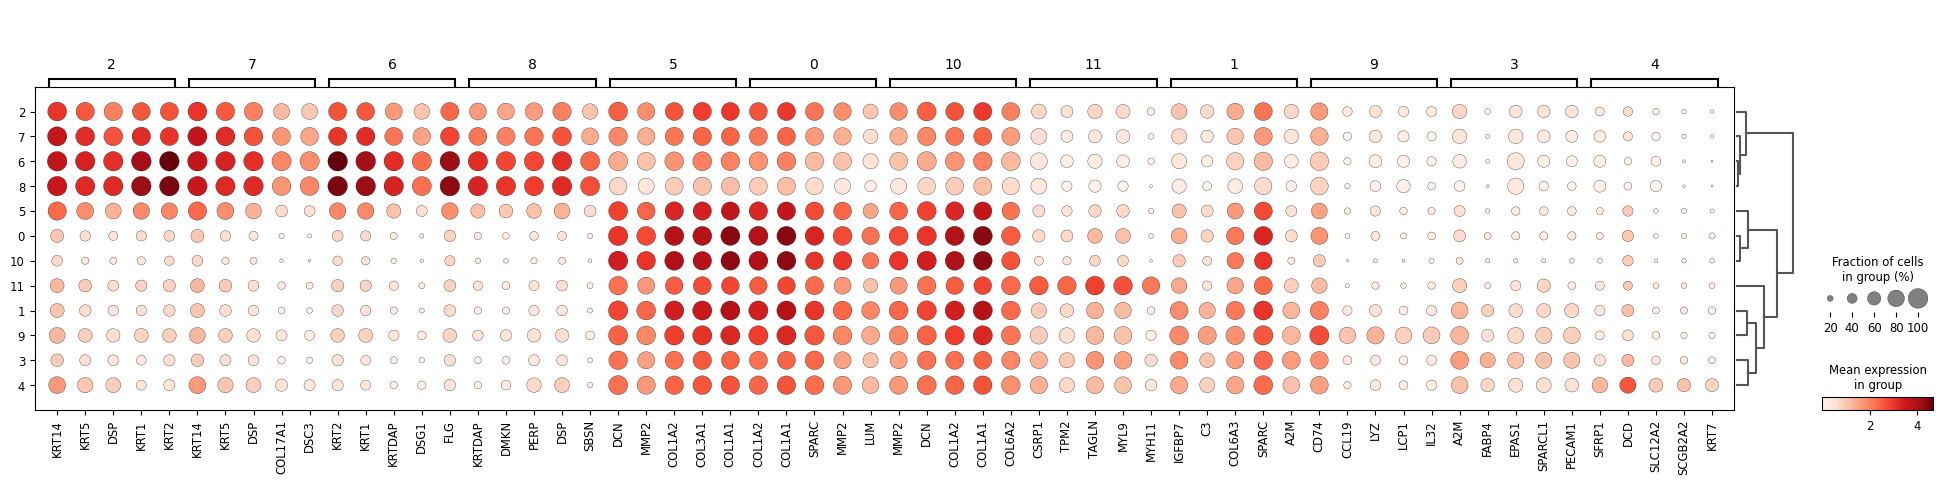

In [36]:
# top 5 markers per niche
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5)

In [58]:
adata.write_h5ad(f"{out_dir}/adata.h5ad")

1 features of mat are empty, they will be removed.
Running mlm on mat with 13204 samples and 13143 targets for 14 sources.


  0%|          | 0/2 [00:00<?, ?it/s]

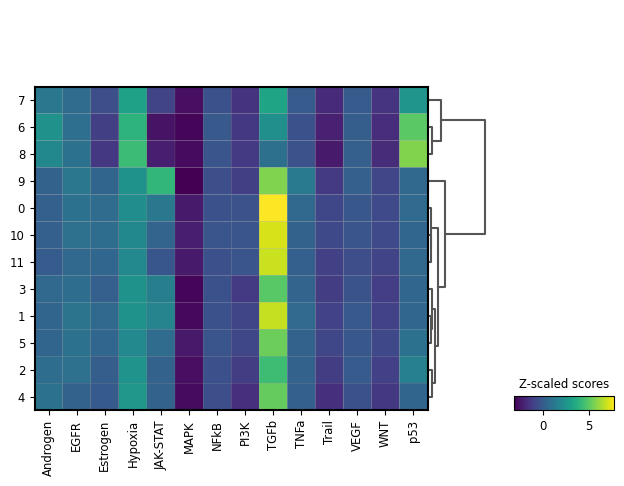

In [11]:
# Pathway activity
progeny = dc.get_progeny(organism='human', top=500)

dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    use_raw=False,
    verbose=True
)

acts = ad.AnnData(X=adata.obsm['mlm_estimate'], obs=adata.obs)

sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='leiden', dendrogram=True, #standard_scale='var',
                 colorbar_title='Z-scaled scores')

acts.write_h5ad(f'{out_dir}/pathway_activity.h5ad')

In [12]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [13]:
# filter msigdb by genes
sel_genes = list(set(msigdb['genesymbol'].values.tolist()) & set(adata.var_names.tolist()))
msigdb = msigdb[msigdb['genesymbol'].isin(sel_genes)]

In [14]:
msigdb.reset_index()

,index,genesymbol,collection,geneset
0,0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...,...
3099539,3837664,KDM5D,immunesigdb,GSE14769_20MIN_VS_360MIN_LPS_BMDM_DN
3099540,3837665,KDM5D,immunesigdb,GSE5099_UNSTIM_VS_MCSF_TREATED_MONOCYTE_DAY7_DN
3099541,3837666,KDM5D,mirna_targets_mirdb,MIR3175
3099542,3837667,KDM5D,human_phenotype_ontology,HP_DECREASED_FERTILITY_IN_MALES


In [ ]:
for collect in msigdb['collection'].cat.categories.tolist():
    print(collect)
    
    # Filter by hallmark
    sel_msigdb = msigdb[msigdb['collection']==collect]

    # Remove duplicated entries
    sel_msigdb = sel_msigdb[~sel_msigdb.duplicated(['geneset', 'genesymbol'])]
    sel_msigdb = sel_msigdb.reset_index()
    
    dc.run_ora(
        mat=adata,
        net=sel_msigdb,
        source='geneset',
        target='genesymbol',
        use_raw=False,
        verbose=False
    )
    
    acts = ad.AnnData(X=adata.obsm['ora_estimate'], 
                      obs=adata.obs, 
                      var=adata.obsm['ora_estimate'].columns.to_frame())
    acts.var['source'] = acts.var.astype('str')
    acts.var_names = acts.var['source']
    acts.write_h5ad(f'{out_dir}/{collect}.h5ad')

biocarta_pathways
cancer_gene_neighborhoods
cancer_modules
